Generate encoded vectors for both query and artist aggregrate images

In [35]:
import read_rijksdata
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pylab as plt
import matplotlib as mpl
MIN_NUM_ARTWORK = 500


In [36]:
# LOAD IMAGE AND LABELS HERE
# replace for your path here!
img_folder = '/Users/erebor/Downloads/out_img'

images, labels_onehot, labels, names, = read_rijksdata.load_data(MIN_NUM_ARTWORK=MIN_NUM_ARTWORK,
                                                 img_folder = img_folder,
                                                 labels_file ='labels.txt',
                                                 names_file = 'names.txt')

 |███████████████████████████████████████-| 112038/112039 

Dataset loaded!
images shape:	 (19007, 56, 56, 3)
labels shape:	 (19007,)
labels (one-hot):	 (19007, 21)
names shape:	 (19007, 1)


In [37]:
classes = len(list(set(labels)))
print('\n# of unique artists:',classes)

counts = pd.DataFrame(labels).value_counts()
print('Min # of artworks for all artists:',min(counts))
print('Min # of artworks specified:',MIN_NUM_ARTWORK)


# of unique artists: 21
Min # of artworks for all artists: 517
Min # of artworks specified: 500


In [58]:
# LOAD PRE-TRAINED ENCODER
# get base pre-trained model first
# more models are available here: https://www.tensorflow.org/api_docs/python/tf/keras/applications

# define hyperparameters
# define image size 
D = 100
input_shape = (56,56,3)

# define number of classes
# ****THIS sets the number of dimensions of the encoded vector ("D") in Mark's email***
# we'll probably want adjust this to be smaller or larger (depending on training results)
# for now, classes are just the number of unique artist
enet_kwargs = {'include_top':False,
               'weights':'imagenet',
               'input_tensor':None,
               'input_shape':input_shape,
               'pooling':None,
               'classes':D,
               'classifier_activation':'softmax'}
enet_base = tf.keras.applications.efficientnet.EfficientNetB7(**enet_kwargs)

# set that the encoder DOES NOT train on the images
enet_base.trainable = False

# set pre-trained model as base
enet = tf.keras.models.Sequential()
enet.add(enet_base)

# add two final top layers
#enet.add(tf.keras.layers.GlobalMaxPooling2D())
enet.add(tf.keras.layers.GlobalMaxPooling2D())
enet.add(tf.keras.layers.Dense(D, activation="softmax")) # last (top) layer of network

In [59]:
enet.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb7 (Functional)  (None, 2, 2, 2560)        64097687  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 2560)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               256100    
Total params: 64,353,787
Trainable params: 256,100
Non-trainable params: 64,097,687
_________________________________________________________________


In [60]:
#images_standard = tf.map_fn(lambda image: tf.image.per_image_standardization(image), images)



In [61]:
# Create encoded tensors for all 
encoded_arts = enet.predict(images,verbose=1)

594/594 [==============================] - 227s 377ms/step


In [69]:
np.max(encoded_arts)

0.04810826

In [70]:
encoded_arts.shape

(19007, 100)

In [71]:
# Count how many pieces each artist has
total_bc = np.bincount(labels) # get count of artists
artcounts = total_bc[np.unique(labels)] # get count of artworks for each unique artist
artistnames = names[np.unique(labels)] # get the name for each unique artist

In [72]:
# Create aggregate vectors
aggregate_vectors = []
for i in range(len(artcounts)):
    artistnum = np.unique(labels)[i] #Gets the number that represents this artist from labels
    artistname = artistnames[i]
    artcount = artcounts[i] #Gets number of art pieces by this artist
    artistaddr = np.where(labels == artistnum) #Collects indices of this artist's art
    #print(artistname,artistnum,artcount)

    # calculate mean (aggregrate) vector for a single artist 
    artist_vector = np.mean(encoded_arts[artistaddr],axis=0)
    aggregate_vectors.append(artist_vector)
      
aggregate_vectors = np.array(aggregate_vectors)

(21, 100)

In [82]:
def plot_aggregates(aggregate_vectors,artistnames,n=3):
    idx = list(range(aggregate_vectors.shape[0]))
    idxs = np.random.choice(a=idx,size=n*n)
    vectors = aggregate_vectors[idxs]
    artists = artistnames[idxs]
    
    fig, axes = plt.subplots(nrows=n,ncols=n,figsize=(9,5))
    for ax_idx, ax in enumerate(fig.axes):
        print(tf.math.sigmoid(vectors[ax_idx]))
        norm = mpl.colors.Normalize(vmin=0.4, vmax=0.6)
        ax.imshow(np.atleast_2d(vectors[ax_idx]), aspect=20, cmap='rainbow', interpolation=None)
        ax.set_xticks([]),ax.set_yticks([])
        ax.set_xlabel(artists[ax_idx][0])
    plt.savefig('figs/aggregrates_sample.png',dpi=200,tight_layout=True)
    plt.show()
    plt.close()

tf.Tensor(
[0.5014653  0.50297093 0.50258714 0.5032058  0.50338024 0.50105184
 0.5026283  0.50139236 0.50418764 0.50309926 0.50185597 0.5038161
 0.5018691  0.50216293 0.5017134  0.5018173  0.50173473 0.50175303
 0.50218695 0.5018902  0.50132823 0.5015637  0.5021351  0.50367254
 0.50445765 0.5010177  0.5018279  0.5014809  0.50389653 0.50505185
 0.5025696  0.50225604 0.50140506 0.5019437  0.5033233  0.50175124
 0.50282353 0.50184983 0.5048569  0.50274837 0.50171906 0.5012705
 0.50199604 0.50343525 0.50343275 0.5018489  0.50384986 0.501556
 0.50249326 0.5010831  0.5013908  0.50188434 0.5018764  0.5029665
 0.5025311  0.504256   0.502492   0.5013114  0.5023877  0.50131804
 0.5014325  0.5051886  0.50176597 0.502203   0.50279194 0.50154287
 0.5018453  0.50229    0.50169194 0.5038033  0.50192225 0.5038592
 0.5031683  0.50197655 0.50217724 0.50351965 0.5021758  0.50448394
 0.50163776 0.50151414 0.50245583 0.50174356 0.50222075 0.5035415
 0.50245756 0.50266397 0.50314903 0.5020404  0.50352937 0.

<ipython-input-82-e4eaa57f477f>:14: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('aggregrates_sample.png',dpi=200,tight_layout=True)


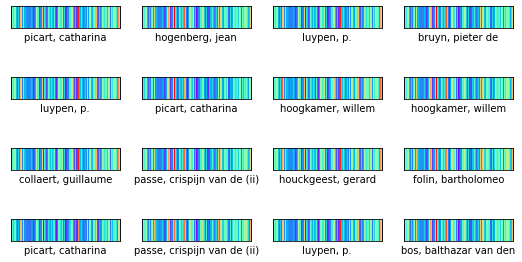

In [83]:
plot_aggregates(aggregate_vectors,artistnames,n=4)

In [ ]:
# Query Image Removal Function
def query_image_remover(qi_vec, avg_vec, artnum):
    new_vec = (tf.math.subtract(avg_vec,  qi_vec * (1/artnum)) * (artnum/(artnum-1)))
    return new_vec